<a href="https://colab.research.google.com/github/newbiepawel/deep_learning_and_other/blob/master/Boltzmann_machine_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
url2 = 'https://raw.githubusercontent.com/srp98/Movie-Recommender-using-RBM/master/ml-1m/ratings.dat'
url3 = 'https://raw.githubusercontent.com/srp98/Movie-Recommender-using-RBM/master/ml-1m/users.dat'

In [3]:

ratings_df = pd.read_csv(url2, sep = '::')
users_df = pd.read_csv(url3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [4]:
from google.colab import files
uploaded = files.upload()

Saving movies.dat to movies.dat


In [5]:

import io
movies_df = pd.read_csv(io.BytesIO(uploaded['movies.dat']), sep = '::', encoding = 'latin-1')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
movies_df.head()

,1,Toy Story (1995),Animation|Children's|Comedy
0,2,Jumanji (1995),Adventure|Children's|Fantasy
1,3,Grumpier Old Men (1995),Comedy|Romance
2,4,Waiting to Exhale (1995),Comedy|Drama
3,5,Father of the Bride Part II (1995),Comedy
4,6,Heat (1995),Action|Crime|Thriller


In [0]:
# Lets rename our columns in these data frames so we can convey their data better
movies_df.columns = ['MovieID', 'Title', 'Genres']
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

In [7]:
# Verify the changes done to the dataframes
print(movies_df.head())
print(ratings_df.head())

   MovieID                               Title                        Genres
0        2                      Jumanji (1995)  Adventure|Children's|Fantasy
1        3             Grumpier Old Men (1995)                Comedy|Romance
2        4            Waiting to Exhale (1995)                  Comedy|Drama
3        5  Father of the Bride Part II (1995)                        Comedy
4        6                         Heat (1995)         Action|Crime|Thriller
   UserID  MovieID  Rating  Timestamp
0       1      661       3  978302109
1       1      914       3  978301968
2       1     3408       4  978300275
3       1     2355       5  978824291
4       1     1197       3  978302268


In [8]:
# Data Correction and Formatting
print('The Number of Movies in Dataset', len(movies_df))

The Number of Movies in Dataset 3882


In [9]:
# Our Movie ID's vary from 1 to 3952 while we have 3883 movies. 
# Due to this, we won't be able to index movies through their ID since we would get memory indexing errors. 
# To amend we can create a column that shows the spot in our list that particular movie is in:
"""



SyntaxError: ignored

In [10]:
movies_df['List Index'] = movies_df.index
print(movies_df.head())

   MovieID  ... List Index
0        2  ...          0
1        3  ...          1
2        4  ...          2
3        5  ...          3
4        6  ...          4

[5 rows x 4 columns]


In [0]:
# Merge movies_df with ratings_df by MovieID
merged_df = movies_df.merge(ratings_df, on='MovieID')

In [0]:
# Drop unnecessary columns
merged_df = merged_df.drop('Timestamp', axis=1).drop('Title', axis=1).drop('Genres', axis=1)

In [13]:
# Display the result
print(merged_df.head())

   MovieID  List Index  UserID  Rating
0        2           0      10       5
1        2           0      13       3
2        2           0      18       2
3        2           0      23       2
4        2           0      27       1


In [14]:
# Lets Group up the Users by their user ID's
user_Group = merged_df.groupby('UserID')
print(user_Group.head())

        MovieID  List Index  UserID  Rating
0             2           0      10       5
1             2           0      13       3
2             2           0      18       2
3             2           0      23       2
4             2           0      27       1
5             2           0      40       5
6             2           0      44       4
7             2           0      48       3
8             2           0      53       5
9             2           0      60       5
10            2           0      62       4
11            2           0      75       4
12            2           0      83       3
13            2           0      92       2
14            2           0     109       4
15            2           0     114       4
16            2           0     119       5
17            2           0     127       3
18            2           0     136       1
19            2           0     146       3
20            2           0     147       4
21            2           0     


"""
Formatting the data into input for the RBM. 
Store the normalized users ratings into a list of lists called trX.
"""

In [0]:

# Amount of users used for training
amountOfUsedUsers = 1000

In [16]:
# Creating the training list
trX = []

# For each user in the group
for userID, curUser in user_Group:

    # Create a temp that stores every movie's rating
    temp = [0]*len(movies_df)

    # For each movie in curUser's movie list
    for num, movie in curUser.iterrows():

        # Divide the rating by 5 and store it
        temp[movie['List Index']] = movie['Rating']/5.0

    # Add the list of ratings into the training list
    trX.append(temp)

    # Check to see if we finished adding in the amount of users for training
    if amountOfUsedUsers == 0:
        break
    amountOfUsedUsers -= 1
print(trX)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
# Setting the models Parameters
hiddenUnits = 50
visibleUnits = len(movies_df)
vb = tf.placeholder(tf.float32, [visibleUnits])  # Number of unique movies
hb = tf.placeholder(tf.float32, [hiddenUnits])  # Number of features were going to learn
W = tf.placeholder(tf.float32, [visibleUnits, hiddenUnits])  # Weight Matrix


In [0]:
# Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)  # Visible layer activation
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))  # Gibb's Sampling

In [0]:

# Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)  # Hidden layer activation
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)


""" Set RBM Training Parameters """


In [0]:

# Learning rate
alpha = 1.0


In [0]:
# Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

In [23]:
# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])


W0816 08:43:25.770721 140515996874624 deprecation.py:323] From <ipython-input-23-28dba45a9886>:1: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


In [0]:
# Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)


In [0]:
# Set the error function, here we use Mean Absolute Error Function
err = v0 - v1
err_sum = tf.reduce_mean(err*err)



""" Initialize our Variables with Zeroes using Numpy Library """

In [0]:
# Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

In [0]:
# Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)

In [0]:
# Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)

In [0]:
# Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

In [0]:
# Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)

In [0]:
# Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0.122328974
0.08231844
0.06760775
0.059724905
0.053300366
0.04950998
0.045729265
0.044471532
0.043240305
0.042743072
0.042097144
0.041431192
0.040980432
0.0406604
0.040358696


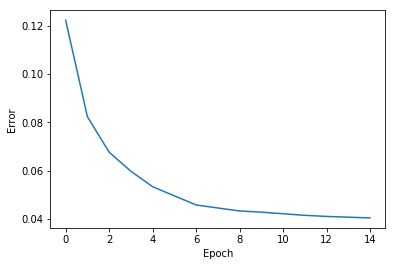

In [32]:
# Train RBM with 15 Epochs, with Each Epoch using 10 batches with size 100, After training print out the error by epoch
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip(range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print(errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()



"""
Recommendation System :-
- We can now predict movies that an arbitrarily selected user might like. 
- This can be accomplished by feeding in the user's watched movie preferences into the RBM and then reconstructing the 
  input. 
- The values that the RBM gives us will attempt to estimate the user's preferences for movies that he hasn't watched 
  based on the preferences of the users that the RBM was trained on.
"""

In [0]:
# Select the input User
inputUser = [trX[50]]

In [0]:
# Feeding in the User and Reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

In [35]:
# List the 20 most recommended movies for our mock user by sorting it by their scores given by our model.
scored_movies_df_50 = movies_df
scored_movies_df_50["Recommendation Score"] = rec[0]
print(scored_movies_df_50.sort_values(["Recommendation Score"], ascending=False).head(20))

      MovieID                        Title  ... List Index  Recommendation Score
2788     2858       American Beauty (1999)  ...       2788              0.739034
3681     3751           Chicken Run (2000)  ...       3681              0.346440
3090     3160              Magnolia (1999)  ...       3090              0.334460
522       527      Schindler's List (1993)  ...        522              0.317381
2927     2997  Being John Malkovich (1999)  ...       2927              0.305897
603       608                 Fargo (1996)  ...        603              0.301152
2529     2599              Election (1999)  ...       2529              0.293774
1574     1617     L.A. Confidential (1997)  ...       1574              0.284363
2326     2396   Shakespeare in Love (1998)  ...       2326              0.281866
3411     3481         High Fidelity (2000)  ...       3411              0.271328
107       110            Braveheart (1995)  ...        107              0.268945
3044     3114           Toy 

""" Recommend User what movies he has not watched yet """

In [0]:
# Find the mock user's UserID from the data
print(merged_df.iloc[50])  # Result you get is UserID 150

In [36]:
# Find all movies the mock user has watched before
movies_df_50 = merged_df[merged_df['UserID'] == 150]
print(movies_df_50.head())

       MovieID  List Index  UserID  Rating
9789        24          22     150       4
10415       25          23     150       4
13890       34          32     150       5
34451      111         108     150       4
38411      144         141     150       4



""" Merge all movies that our mock users has watched with predicted scores based on his historical data: """

In [0]:
# Merging movies_df with ratings_df by MovieID
merged_df_50 = scored_movies_df_50.merge(movies_df_50, on='MovieID', how='outer')

In [0]:
# Dropping unnecessary columns
merged_df_50 = merged_df_50.drop('List Index_y', axis=1).drop('UserID', axis=1)

In [39]:
# Sort and take a look at first 20 rows
print(merged_df_50.sort_values(['Recommendation Score'], ascending=False).head(20))

""" There are some movies the user has not watched and has high score based on our model. So, we can recommend them. """

      MovieID                        Title  ... Recommendation Score  Rating
2788     2858       American Beauty (1999)  ...             0.739034     5.0
3681     3751           Chicken Run (2000)  ...             0.346440     4.0
3090     3160              Magnolia (1999)  ...             0.334460     3.0
522       527      Schindler's List (1993)  ...             0.317381     4.0
2927     2997  Being John Malkovich (1999)  ...             0.305897     4.0
603       608                 Fargo (1996)  ...             0.301152     5.0
2529     2599              Election (1999)  ...             0.293774     3.0
1574     1617     L.A. Confidential (1997)  ...             0.284363     4.0
2326     2396   Shakespeare in Love (1998)  ...             0.281866     5.0
3411     3481         High Fidelity (2000)  ...             0.271328     4.0
107       110            Braveheart (1995)  ...             0.268945     NaN
3044     3114           Toy Story 2 (1999)  ...             0.262987     NaN

' There are some movies the user has not watched and has high score based on our model. So, we can recommend them. '